## Execute localy for DEV

In [ ]:
# Only for the development purposes
# Autosync with updated files
%load_ext autoreload
%autoreload 2

## Execute in Colab environment

In [1]:
# Execute in Colab environment
!git clone https://github.com/CharNoir/DL-BotGuard.git
!cp -r DL-BotGuard/sw/ /content/
!rm -rf DL-BotGuard

Cloning into 'DL-BotGuard'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 134 (delta 41), reused 113 (delta 31), pack-reused 0 (from 0)
Receiving objects: 100% (134/134), 7.08 MiB | 18.59 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [ ]:
%cd /content/
from sw.download_datasets import ensure_all_downloaded
ensure_all_downloaded()

In [3]:
import os
os.chdir("/content/sw")
os.getcwd()

'/content/sw'

In [4]:
RELATIVE_FOLDER = "/content/"

## Imports

In [5]:
import numpy as np
import pandas as pd
import torch

import wandb

from sklearn.metrics import accuracy_score

from config import ConfigLoader
from data_loader import (
    load_folder,
    df_to_sequence_windows,
    split_and_scale_sequence,
)

from models.torch_models import GRUMouseNet

from training.trainer_torch import train_torch

from evaluation.eval_sequence import evaluate_with_thresholds
from evaluation.plots import plot_accuracy, plot_f1, plot_recall, plot_precision, plot_precision_recall_both_classes


In [6]:
BEST_MODEL_PATH = "gru_own_best.pth"

## Loading dataset

In [7]:
try:
    RELATIVE_FOLDER
except Exception as e:
    RELATIVE_FOLDER = "../"

BASE = os.path.join(RELATIVE_FOLDER, "data/raw/")

df_user, _ = load_folder(f"{BASE}/our_dataset/v1/mouse", label=0)
df_att, _ = load_folder(f"{BASE}/our_bot_dataset/v1/mouse", label=1)

df_user = df_user.iloc[:10_000].copy()

boun_df = pd.concat([df_user, df_att], ignore_index=True)

X_boun, y_boun = df_to_sequence_windows(
    boun_df,
    window_size=100,
    step=50,
    feature_cols=["x", "y", "dx", "dy", "dt", "speed"],
)


In [8]:
X_train, X_val, X_test, y_train, y_val, y_test, scaler = split_and_scale_sequence(X_boun, y_boun)

## Setup and run sweep

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def sweep_train_gru(config=None):
    """Single sweep pass for GRUMouseNet."""
    with wandb.init(config=config, project="mouse-our-gru"):
        cfg = wandb.config
        model = GRUMouseNet.from_config(cfg, input_dim=X_train.shape[2])

        # Train
        model = train_torch(
            model,
            X_train,
            y_train,
            X_val=X_val,
            y_val=y_val,
            epochs=cfg.epochs,
            batch_size=cfg.batch_size,
            lr=cfg.lr,
            wandb_run=wandb,
            save_best_path=BEST_MODEL_PATH,
        )

        # Validation accuracy
        model.to(device)
        model.eval()
        with torch.no_grad():
            logits = model(torch.tensor(X_val, dtype=torch.float32, device=device))
            y_pred = logits.argmax(dim=1).cpu().numpy()

        val_acc = accuracy_score(y_val, y_pred)
        wandb.log({"val_accuracy": val_acc})


# Sweep configuration
sweep_config_gru = {
    "method": "random",
    "metric": {"name": "val_accuracy", "goal": "maximize"},
    "parameters": {
        "hidden_dim":    {"values": [32, 64, 128]},
        "num_layers":    {"values": [1, 2]},
        "bidirectional": {"values": [True]},
        "dropout":       {"values": [0.0, 0.1, 0.3]},
        "epochs":        {"values": [10, 15]},
        "batch_size":    {"values": [64, 128]},
        "lr":            {"values": [3e-4, 1e-3, 3e-3]},
    },
}

# Start sweep
sweep_id = wandb.sweep(sweep_config_gru, project="mouse-boun-gru")
wandb.agent(sweep_id, function=sweep_train_gru, count=50)


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: e52b7jkg
Sweep URL: https://wandb.ai/char_noir-budapesti-m-szaki-s-gazdas-gtudom-nyi-egyetem/mouse-boun-gru/sweeps/e52b7jkg


wandb: Agent Starting Run: 7wtdm8uh with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	hidden_dim: 32
wandb: 	lr: 0.001
wandb: 	num_layers: 1
wandb: Currently logged in as: char_noir (char_noir-budapesti-m-szaki-s-gazdas-gtudom-nyi-egyetem) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/10: loss=0.6805, val_acc=0.5614035129547119
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6724, val_acc=0.5438596606254578
Epoch 3/10: loss=0.6613, val_acc=0.5614035129547119
Epoch 4/10: loss=0.6503, val_acc=0.5964912176132202
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/10: loss=0.6378, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 6/10: loss=0.6246, val_acc=0.6666666865348816
Epoch 7/10: loss=0.6130, val_acc=0.6491228342056274
Epoch 8/10: loss=0.5960, val_acc=0.6315789222717285
Epoch 9/10: loss=0.5842, val_acc=0.6315789222717285
Epoch 10/10: loss=0.5626, val_acc=0.6491228342056274


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,██▇▆▅▅▄▃▂▁
val_accuracy,▂▁▂▄██▇▆▆▇▇
epoch,10
train_loss,0.56257
val_accuracy,0.64912


wandb: Agent Starting Run: ug26cifw with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	hidden_dim: 32
wandb: 	lr: 0.0003
wandb: 	num_layers: 2


Epoch 1/10: loss=0.6952, val_acc=0.3684210479259491
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6930, val_acc=0.5263158082962036
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/10: loss=0.6897, val_acc=0.5438596606254578
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/10: loss=0.6872, val_acc=0.5964912176132202
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/10: loss=0.6842, val_acc=0.5614035129547119
Epoch 6/10: loss=0.6820, val_acc=0.5964912176132202
Epoch 7/10: loss=0.6797, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 8/10: loss=0.6760, val_acc=0.6140350699424744
Epoch 9/10: loss=0.6747, val_acc=0.6140350699424744
Epoch 10/10: loss=0.6692, val_acc=0.6140350699424744


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▇▆▅▄▄▃▂▁
val_accuracy,▁▆▆█▇██████
epoch,10
train_loss,0.66919
val_accuracy,0.61404


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0u9rjgag with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_dim: 64
wandb: 	lr: 0.003
wandb: 	num_layers: 2


Epoch 1/15: loss=0.6854, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6561, val_acc=0.6140350699424744
Epoch 3/15: loss=0.6196, val_acc=0.5964912176132202
Epoch 4/15: loss=0.5844, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/15: loss=0.5388, val_acc=0.6491228342056274
Epoch 6/15: loss=0.4999, val_acc=0.7543859481811523
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/15: loss=0.4512, val_acc=0.8245614171028137
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 8/15: loss=0.4100, val_acc=0.859649121761322
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 9/15: loss=0.3628, val_acc=0.8947368264198303
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 10/15: loss=0.3331, val

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,██▇▆▆▅▄▄▃▃▃▂▂▁▁
val_accuracy,▁▁▁▃▂▅▆▇█████▇▇▇
epoch,15
train_loss,0.23277
val_accuracy,0.84211


wandb: Agent Starting Run: 997rxfsf with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	lr: 0.001
wandb: 	num_layers: 1


Epoch 1/15: loss=0.6856, val_acc=0.5614035129547119
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6725, val_acc=0.5438596606254578
Epoch 3/15: loss=0.6632, val_acc=0.5789473652839661
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/15: loss=0.6529, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/15: loss=0.6383, val_acc=0.5964912176132202
Epoch 6/15: loss=0.6247, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/15: loss=0.6149, val_acc=0.6315789222717285
Epoch 8/15: loss=0.5911, val_acc=0.6315789222717285
Epoch 9/15: loss=0.5685, val_acc=0.6491228342056274
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 10/15: loss=0.5540, val_acc=0.6315789222717285
Epoch 11/15: loss=0.5237, val_acc=0.6666666865348816
New be

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,██▇▇▇▆▆▅▅▄▃▃▂▂▁
val_accuracy,▂▁▃▄▃▅▅▅▆▅▆▇▆▆██
epoch,15
train_loss,0.44876
val_accuracy,0.70175


wandb: Agent Starting Run: 6a836c7t with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	lr: 0.0003
wandb: 	num_layers: 1


Epoch 1/10: loss=0.6873, val_acc=0.5614035129547119
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6783, val_acc=0.5789473652839661
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/10: loss=0.6679, val_acc=0.6491228342056274
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/10: loss=0.6629, val_acc=0.6315789222717285
Epoch 5/10: loss=0.6529, val_acc=0.6491228342056274
Epoch 6/10: loss=0.6526, val_acc=0.6315789222717285
Epoch 7/10: loss=0.6396, val_acc=0.6140350699424744
Epoch 8/10: loss=0.6393, val_acc=0.6315789222717285
Epoch 9/10: loss=0.6238, val_acc=0.6140350699424744
Epoch 10/10: loss=0.6152, val_acc=0.6315789222717285


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▆▅▅▃▃▂▁
val_accuracy,▁▂█▇█▇▅▇▅▇▇
epoch,10
train_loss,0.61521
val_accuracy,0.63158


wandb: Agent Starting Run: 59scgvw0 with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0.1
wandb: 	epochs: 15
wandb: 	hidden_dim: 32
wandb: 	lr: 0.001
wandb: 	num_layers: 1


Epoch 1/15: loss=0.6828, val_acc=0.5614035129547119
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6710, val_acc=0.5438596606254578
Epoch 3/15: loss=0.6612, val_acc=0.5438596606254578
Epoch 4/15: loss=0.6532, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/15: loss=0.6433, val_acc=0.6140350699424744
Epoch 6/15: loss=0.6294, val_acc=0.6140350699424744
Epoch 7/15: loss=0.6272, val_acc=0.5964912176132202
Epoch 8/15: loss=0.6075, val_acc=0.6140350699424744
Epoch 9/15: loss=0.5972, val_acc=0.6140350699424744
Epoch 10/15: loss=0.5826, val_acc=0.6140350699424744
Epoch 11/15: loss=0.5671, val_acc=0.6491228342056274
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 12/15: loss=0.5483, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 13/15: loss=0.5099, val_acc=0.6

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,██▇▇▇▆▆▅▅▅▄▃▂▂▁
val_accuracy,▂▁▁▅▄▄▃▄▄▄▆▆▇███
epoch,15
train_loss,0.4796
val_accuracy,0.70175


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: id2ywysy with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_dim: 32
wandb: 	lr: 0.003
wandb: 	num_layers: 2


Epoch 1/15: loss=0.6816, val_acc=0.5964912176132202
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6441, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/15: loss=0.6173, val_acc=0.6315789222717285
Epoch 4/15: loss=0.5541, val_acc=0.6842105388641357
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/15: loss=0.4880, val_acc=0.719298243522644
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 6/15: loss=0.4429, val_acc=0.7894737124443054
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/15: loss=0.3749, val_acc=0.859649121761322
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 8/15: loss=0.3223, val_acc=0.8947368264198303
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pt

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▇▇▆▅▅▄▃▂▂▂▂▁▁▁
val_accuracy,▁▃▂▃▄▅▇██▇▇▇▇▇▇▇
epoch,15
train_loss,0.18458
val_accuracy,0.87719


wandb: Agent Starting Run: upldlze9 with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0.1
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	lr: 0.003
wandb: 	num_layers: 2


Epoch 1/10: loss=0.6805, val_acc=0.5964912176132202
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6148, val_acc=0.5789473652839661
Epoch 3/10: loss=0.5570, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/10: loss=0.4870, val_acc=0.719298243522644
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/10: loss=0.4365, val_acc=0.7543859481811523
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 6/10: loss=0.3698, val_acc=0.7719298601150513
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/10: loss=0.3567, val_acc=0.8421052694320679
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 8/10: loss=0.3543, val_acc=0.8771929740905762
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.p

epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▄▄▂▂▂▃▁
val_accuracy,▁▁▂▄▅▆▇████
epoch,10
train_loss,0.29949
val_accuracy,0.87719


wandb: Agent Starting Run: 3q8c1stt with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	hidden_dim: 32
wandb: 	lr: 0.001
wandb: 	num_layers: 2


Epoch 1/15: loss=0.6872, val_acc=0.5614035129547119
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6784, val_acc=0.5614035129547119
Epoch 3/15: loss=0.6656, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/15: loss=0.6542, val_acc=0.6491228342056274
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/15: loss=0.6384, val_acc=0.6842105388641357
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 6/15: loss=0.6256, val_acc=0.6666666865348816
Epoch 7/15: loss=0.6099, val_acc=0.6491228342056274
Epoch 8/15: loss=0.5786, val_acc=0.6666666865348816
Epoch 9/15: loss=0.5486, val_acc=0.6842105388641357
Epoch 10/15: loss=0.5264, val_acc=0.719298243522644
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 11/15: loss=0.4890, val_acc=0.8070175647735596
New bes

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,███▇▇▇▆▅▅▄▃▃▂▂▁
val_accuracy,▁▁▃▃▄▃▃▃▄▅▆▇▇███
epoch,15
train_loss,0.38389
val_accuracy,0.87719


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nlmr73da with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	hidden_dim: 64
wandb: 	lr: 0.003
wandb: 	num_layers: 1


Epoch 1/10: loss=0.7004, val_acc=0.5614035129547119
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6725, val_acc=0.6491228342056274
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/10: loss=0.6425, val_acc=0.6315789222717285
Epoch 4/10: loss=0.6164, val_acc=0.6315789222717285
Epoch 5/10: loss=0.5940, val_acc=0.6491228342056274
Epoch 6/10: loss=0.5630, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/10: loss=0.5407, val_acc=0.6666666865348816
Epoch 8/10: loss=0.5097, val_acc=0.6842105388641357
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 9/10: loss=0.4949, val_acc=0.6491228342056274
Epoch 10/10: loss=0.4775, val_acc=0.719298243522644
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▅▅▄▃▂▂▁
val_accuracy,▁▅▄▄▅▆▆▆▅██
epoch,10
train_loss,0.4775
val_accuracy,0.7193


wandb: Agent Starting Run: xfh9p3uf with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0.1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	lr: 0.001
wandb: 	num_layers: 2


Epoch 1/15: loss=0.6934, val_acc=0.5438596606254578
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6691, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/15: loss=0.6486, val_acc=0.6315789222717285
Epoch 4/15: loss=0.6245, val_acc=0.6140350699424744
Epoch 5/15: loss=0.5959, val_acc=0.5964912176132202
Epoch 6/15: loss=0.5851, val_acc=0.6491228342056274
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/15: loss=0.5599, val_acc=0.6491228342056274
Epoch 8/15: loss=0.5469, val_acc=0.6491228342056274
Epoch 9/15: loss=0.5097, val_acc=0.7017543911933899
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 10/15: loss=0.4967, val_acc=0.7368420958518982
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 11/15: loss=0.4588, val_acc=0.7543859481811523
New be

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▇▇▇▆▆▅▅▄▄▃▃▂▁▁
val_accuracy,▁▃▃▃▂▃▃▃▅▆▆▇████
epoch,15
train_loss,0.36307
val_accuracy,0.82456


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6gghpkk0 with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0.1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	lr: 0.003
wandb: 	num_layers: 2


Epoch 1/15: loss=0.6644, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.5677, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/15: loss=0.4859, val_acc=0.7017543911933899
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/15: loss=0.4642, val_acc=0.719298243522644
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/15: loss=0.4243, val_acc=0.8245614171028137
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 6/15: loss=0.4525, val_acc=0.719298243522644
Epoch 7/15: loss=0.3593, val_acc=0.859649121761322
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 8/15: loss=0.3143, val_acc=0.8771929740905762
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▇▅▅▄▅▃▃▂▂▂▂▁▁▁
val_accuracy,▁▂▃▃▆▃▆▇▇▅█▆█▇▇▇
epoch,15
train_loss,0.21504
val_accuracy,0.89474


wandb: Agent Starting Run: 2wxdoixn with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0.1
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	lr: 0.0003
wandb: 	num_layers: 2


Epoch 1/10: loss=0.6919, val_acc=0.5789473652839661
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6840, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/10: loss=0.6781, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/10: loss=0.6708, val_acc=0.6315789222717285
Epoch 5/10: loss=0.6656, val_acc=0.6315789222717285
Epoch 6/10: loss=0.6584, val_acc=0.6315789222717285
Epoch 7/10: loss=0.6506, val_acc=0.6315789222717285
Epoch 8/10: loss=0.6459, val_acc=0.6140350699424744
Epoch 9/10: loss=0.6386, val_acc=0.6140350699424744
Epoch 10/10: loss=0.6350, val_acc=0.6140350699424744


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▅▅▄▃▂▁▁
val_accuracy,▁▆█████▆▆▆▆
epoch,10
train_loss,0.63499
val_accuracy,0.61404


wandb: Agent Starting Run: af8z5ns7 with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	lr: 0.001
wandb: 	num_layers: 2


Epoch 1/15: loss=0.6894, val_acc=0.5964912176132202
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6685, val_acc=0.5964912176132202
Epoch 3/15: loss=0.6493, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/15: loss=0.6233, val_acc=0.5964912176132202
Epoch 5/15: loss=0.6028, val_acc=0.6140350699424744
Epoch 6/15: loss=0.5805, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/15: loss=0.5505, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 8/15: loss=0.5175, val_acc=0.719298243522644
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 9/15: loss=0.5038, val_acc=0.7368420958518982
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 10/15: loss=0.4688, val

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,██▇▇▆▆▅▄▄▃▃▃▂▂▁
val_accuracy,▁▁▁▁▁▂▃▅▅▇█▇▇▇▇▇
epoch,15
train_loss,0.34881
val_accuracy,0.78947


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9hl07k2n with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	lr: 0.0003
wandb: 	num_layers: 2


Epoch 1/15: loss=0.7045, val_acc=0.4385964870452881
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6866, val_acc=0.5964912176132202
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/15: loss=0.6745, val_acc=0.6491228342056274
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/15: loss=0.6596, val_acc=0.6140350699424744
Epoch 5/15: loss=0.6519, val_acc=0.6140350699424744
Epoch 6/15: loss=0.6372, val_acc=0.6315789222717285
Epoch 7/15: loss=0.6309, val_acc=0.6140350699424744
Epoch 8/15: loss=0.6150, val_acc=0.6140350699424744
Epoch 9/15: loss=0.5966, val_acc=0.6140350699424744
Epoch 10/15: loss=0.6020, val_acc=0.6140350699424744
Epoch 11/15: loss=0.5883, val_acc=0.6491228342056274
Epoch 12/15: loss=0.5677, val_acc=0.6842105388641357
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 13/15: loss=0.5489, val_acc=0.6

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▇▇▆▆▅▅▅▄▄▄▃▂▂▁
val_accuracy,▁▅▇▆▆▆▆▆▆▆▇█▇▇██
epoch,15
train_loss,0.51766
val_accuracy,0.70175


wandb: Agent Starting Run: 8jhmeylm with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	hidden_dim: 32
wandb: 	lr: 0.003
wandb: 	num_layers: 1


Epoch 1/10: loss=0.6967, val_acc=0.6491228342056274
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6710, val_acc=0.6315789222717285
Epoch 3/10: loss=0.6486, val_acc=0.5964912176132202
Epoch 4/10: loss=0.6314, val_acc=0.5964912176132202
Epoch 5/10: loss=0.6098, val_acc=0.5964912176132202
Epoch 6/10: loss=0.5949, val_acc=0.5964912176132202
Epoch 7/10: loss=0.5823, val_acc=0.6315789222717285
Epoch 8/10: loss=0.5720, val_acc=0.6491228342056274
Epoch 9/10: loss=0.5523, val_acc=0.6491228342056274
Epoch 10/10: loss=0.5304, val_acc=0.6491228342056274


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▅▄▄▃▃▂▁
val_accuracy,█▆▁▁▁▁▆████
epoch,10
train_loss,0.53041
val_accuracy,0.64912


wandb: Agent Starting Run: lxilebae with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	lr: 0.0003
wandb: 	num_layers: 2


Epoch 1/15: loss=0.6863, val_acc=0.5614035129547119
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6779, val_acc=0.5438596606254578
Epoch 3/15: loss=0.6739, val_acc=0.5964912176132202
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/15: loss=0.6567, val_acc=0.6491228342056274
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/15: loss=0.6495, val_acc=0.6140350699424744
Epoch 6/15: loss=0.6335, val_acc=0.6315789222717285
Epoch 7/15: loss=0.6237, val_acc=0.6491228342056274
Epoch 8/15: loss=0.5984, val_acc=0.6491228342056274
Epoch 9/15: loss=0.5821, val_acc=0.6491228342056274
Epoch 10/15: loss=0.5478, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 11/15: loss=0.5238, val_acc=0.6666666865348816
Epoch 12/15: loss=0.5174, val_acc=0.7017543911933899
New best model discovered! Saving to 

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,███▇▇▆▆▅▅▄▃▃▂▂▁
val_accuracy,▂▁▃▄▃▄▄▄▄▅▅▆▅▇██
epoch,15
train_loss,0.45489
val_accuracy,0.77193


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3uaarq5p with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	hidden_dim: 32
wandb: 	lr: 0.0003
wandb: 	num_layers: 1


Epoch 1/15: loss=0.6931, val_acc=0.5964912176132202
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6899, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/15: loss=0.6867, val_acc=0.6140350699424744
Epoch 4/15: loss=0.6830, val_acc=0.6666666865348816
Epoch 5/15: loss=0.6800, val_acc=0.6666666865348816
Epoch 6/15: loss=0.6769, val_acc=0.7017543911933899
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/15: loss=0.6748, val_acc=0.6842105388641357
Epoch 8/15: loss=0.6731, val_acc=0.6666666865348816
Epoch 9/15: loss=0.6699, val_acc=0.6491228342056274
Epoch 10/15: loss=0.6663, val_acc=0.6666666865348816
Epoch 11/15: loss=0.6621, val_acc=0.6666666865348816
Epoch 12/15: loss=0.6607, val_acc=0.6666666865348816
Epoch 13/15: loss=0.6570, val_acc=0.6666666865348816
Epoch 14/15: loss=0.6547, val_acc=0.6666666865348816
Epoch 15/15: lo

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▇▇▆▆▅▅▅▄▄▃▃▂▂▁
val_accuracy,▁▆▂▆▆█▇▆▅▆▆▆▆▆▃▃
epoch,15
train_loss,0.65088
val_accuracy,0.63158


wandb: Agent Starting Run: s2jzoozl with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	lr: 0.0003
wandb: 	num_layers: 2


Epoch 1/15: loss=0.6855, val_acc=0.5614035129547119
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6800, val_acc=0.5614035129547119
Epoch 3/15: loss=0.6747, val_acc=0.5438596606254578
Epoch 4/15: loss=0.6692, val_acc=0.5438596606254578
Epoch 5/15: loss=0.6621, val_acc=0.5438596606254578
Epoch 6/15: loss=0.6581, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/15: loss=0.6534, val_acc=0.5964912176132202
Epoch 8/15: loss=0.6475, val_acc=0.5964912176132202
Epoch 9/15: loss=0.6414, val_acc=0.5789473652839661
Epoch 10/15: loss=0.6327, val_acc=0.5964912176132202
Epoch 11/15: loss=0.6287, val_acc=0.6140350699424744
Epoch 12/15: loss=0.6180, val_acc=0.6140350699424744
Epoch 13/15: loss=0.6158, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 14/15: loss=0.6015, val_acc=0.6140350699424744
Epoch 15/15: lo

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,██▇▇▆▆▅▅▄▄▃▃▂▁▁
val_accuracy,▂▂▁▁▁▇▅▅▄▅▇▇█▇▅▅
epoch,15
train_loss,0.5995
val_accuracy,0.59649


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jvzmubon with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	lr: 0.001
wandb: 	num_layers: 1


Epoch 1/15: loss=0.6972, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6714, val_acc=0.5964912176132202
Epoch 3/15: loss=0.6498, val_acc=0.5789473652839661
Epoch 4/15: loss=0.6323, val_acc=0.6140350699424744
Epoch 5/15: loss=0.6007, val_acc=0.6140350699424744
Epoch 6/15: loss=0.5599, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/15: loss=0.5341, val_acc=0.6666666865348816
Epoch 8/15: loss=0.5112, val_acc=0.719298243522644
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 9/15: loss=0.4868, val_acc=0.7894737124443054
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 10/15: loss=0.4918, val_acc=0.7543859481811523
Epoch 11/15: loss=0.4516, val_acc=0.7543859481811523
Epoch 12/15: loss=0.4520, val_acc=0.7719298601150513
Epoch 13/15: loss=0.4307, val_acc=0.78

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▇▇▇▆▅▄▄▃▄▃▃▂▁▁
val_accuracy,▂▁▁▂▂▃▃▅▆▅▅▆▆▇██
epoch,15
train_loss,0.37201
val_accuracy,0.85965


wandb: Agent Starting Run: yl67hp34 with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	hidden_dim: 64
wandb: 	lr: 0.003
wandb: 	num_layers: 1


Epoch 1/10: loss=0.6913, val_acc=0.719298243522644
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6619, val_acc=0.6666666865348816
Epoch 3/10: loss=0.6340, val_acc=0.6842105388641357
Epoch 4/10: loss=0.6066, val_acc=0.6842105388641357
Epoch 5/10: loss=0.5700, val_acc=0.6666666865348816
Epoch 6/10: loss=0.5503, val_acc=0.7017543911933899
Epoch 7/10: loss=0.5201, val_acc=0.7017543911933899
Epoch 8/10: loss=0.4890, val_acc=0.7719298601150513
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 9/10: loss=0.4690, val_acc=0.7894737124443054
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 10/10: loss=0.4373, val_acc=0.7894737124443054


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▆▅▄▃▂▂▁
val_accuracy,▄▁▂▂▁▃▃▇███
epoch,10
train_loss,0.43727
val_accuracy,0.78947


wandb: Agent Starting Run: h3ss5x4l with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	hidden_dim: 64
wandb: 	lr: 0.001
wandb: 	num_layers: 1


Epoch 1/10: loss=0.6904, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6798, val_acc=0.6140350699424744
Epoch 3/10: loss=0.6698, val_acc=0.6140350699424744
Epoch 4/10: loss=0.6592, val_acc=0.6315789222717285
Epoch 5/10: loss=0.6494, val_acc=0.6140350699424744
Epoch 6/10: loss=0.6394, val_acc=0.6140350699424744
Epoch 7/10: loss=0.6317, val_acc=0.6315789222717285
Epoch 8/10: loss=0.6229, val_acc=0.6315789222717285
Epoch 9/10: loss=0.6157, val_acc=0.6140350699424744
Epoch 10/10: loss=0.6056, val_acc=0.6140350699424744


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▅▅▄▃▂▂▁
val_accuracy,█▁▁█▁▁██▁▁▁
epoch,10
train_loss,0.60557
val_accuracy,0.61404


wandb: Agent Starting Run: rhnvsof1 with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	hidden_dim: 64
wandb: 	lr: 0.003
wandb: 	num_layers: 2


Epoch 1/10: loss=0.6867, val_acc=0.5964912176132202
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6595, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/10: loss=0.6251, val_acc=0.5964912176132202
Epoch 4/10: loss=0.5908, val_acc=0.6140350699424744
Epoch 5/10: loss=0.5637, val_acc=0.6491228342056274
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 6/10: loss=0.5279, val_acc=0.7719298601150513
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/10: loss=0.4845, val_acc=0.719298243522644
Epoch 8/10: loss=0.4513, val_acc=0.8245614171028137
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 9/10: loss=0.3894, val_acc=0.859649121761322
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 10/10: loss=0.3769, val_

epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▇▆▅▄▃▃▁▁
val_accuracy,▁▁▁▁▂▆▄▇███
epoch,10
train_loss,0.3769
val_accuracy,0.84211


wandb: Agent Starting Run: jq0wr2ob with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	lr: 0.0003
wandb: 	num_layers: 1


Epoch 1/15: loss=0.6825, val_acc=0.5614035129547119
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6734, val_acc=0.5614035129547119
Epoch 3/15: loss=0.6711, val_acc=0.5614035129547119
Epoch 4/15: loss=0.6621, val_acc=0.5614035129547119
Epoch 5/15: loss=0.6510, val_acc=0.5614035129547119
Epoch 6/15: loss=0.6470, val_acc=0.5438596606254578
Epoch 7/15: loss=0.6380, val_acc=0.5614035129547119
Epoch 8/15: loss=0.6324, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 9/15: loss=0.6171, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 10/15: loss=0.6069, val_acc=0.6842105388641357
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 11/15: loss=0.5938, val_acc=0.6842105388641357
Epoch 12/15: loss=0.5843, val_acc=0.7017543911933899
New best model discovered! Saving to 

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,██▇▇▆▆▆▅▅▄▄▃▂▁▁
val_accuracy,▂▂▂▂▂▁▂▄▅▆▆▆▆▇██
epoch,15
train_loss,0.54563
val_accuracy,0.75439


wandb: Agent Starting Run: 45ti26nz with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	hidden_dim: 64
wandb: 	lr: 0.003
wandb: 	num_layers: 2


Epoch 1/10: loss=0.6746, val_acc=0.5789473652839661
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6194, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/10: loss=0.5787, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/10: loss=0.5253, val_acc=0.6491228342056274
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/10: loss=0.5043, val_acc=0.7368420958518982
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 6/10: loss=0.4477, val_acc=0.7543859481811523
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/10: loss=0.4159, val_acc=0.7894737124443054
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 8/10: loss=0.3601, val_acc=0.8596491217613

epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▅▅▄▃▂▂▁
val_accuracy,▁▂▂▃▅▅▆▇▇██
epoch,10
train_loss,0.28595
val_accuracy,0.89474


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8nep21y3 with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0.1
wandb: 	epochs: 15
wandb: 	hidden_dim: 32
wandb: 	lr: 0.0003
wandb: 	num_layers: 1


Epoch 1/15: loss=0.6852, val_acc=0.5614035129547119
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6819, val_acc=0.5614035129547119
Epoch 3/15: loss=0.6812, val_acc=0.5614035129547119
Epoch 4/15: loss=0.6785, val_acc=0.5614035129547119
Epoch 5/15: loss=0.6764, val_acc=0.5614035129547119
Epoch 6/15: loss=0.6748, val_acc=0.5614035129547119
Epoch 7/15: loss=0.6719, val_acc=0.5614035129547119
Epoch 8/15: loss=0.6708, val_acc=0.5614035129547119
Epoch 9/15: loss=0.6680, val_acc=0.5614035129547119
Epoch 10/15: loss=0.6664, val_acc=0.5614035129547119
Epoch 11/15: loss=0.6631, val_acc=0.5614035129547119
Epoch 12/15: loss=0.6619, val_acc=0.5614035129547119
Epoch 13/15: loss=0.6610, val_acc=0.5614035129547119
Epoch 14/15: loss=0.6595, val_acc=0.5614035129547119
Epoch 15/15: loss=0.6568, val_acc=0.5614035129547119


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▇▇▆▆▅▅▄▄▃▃▂▂▂▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
train_loss,0.65678
val_accuracy,0.5614


wandb: Agent Starting Run: 4kncy9zl with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	hidden_dim: 64
wandb: 	lr: 0.0003
wandb: 	num_layers: 1


Epoch 1/10: loss=0.6929, val_acc=0.4385964870452881
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6898, val_acc=0.5964912176132202
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/10: loss=0.6868, val_acc=0.5964912176132202
Epoch 4/10: loss=0.6843, val_acc=0.5789473652839661
Epoch 5/10: loss=0.6815, val_acc=0.5614035129547119
Epoch 6/10: loss=0.6786, val_acc=0.5614035129547119
Epoch 7/10: loss=0.6761, val_acc=0.5789473652839661
Epoch 8/10: loss=0.6734, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 9/10: loss=0.6714, val_acc=0.6140350699424744
Epoch 10/10: loss=0.6685, val_acc=0.6140350699424744


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▆▅▄▃▂▂▁
val_accuracy,▁▇▇▇▆▆▇████
epoch,10
train_loss,0.66846
val_accuracy,0.61404


wandb: Agent Starting Run: 8cqhr6t8 with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	hidden_dim: 64
wandb: 	lr: 0.003
wandb: 	num_layers: 1


Epoch 1/15: loss=0.6856, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6642, val_acc=0.5964912176132202
Epoch 3/15: loss=0.6429, val_acc=0.5964912176132202
Epoch 4/15: loss=0.6215, val_acc=0.5964912176132202
Epoch 5/15: loss=0.5974, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 6/15: loss=0.5685, val_acc=0.6491228342056274
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/15: loss=0.5504, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 8/15: loss=0.5153, val_acc=0.6491228342056274
Epoch 9/15: loss=0.4970, val_acc=0.6666666865348816
Epoch 10/15: loss=0.4807, val_acc=0.7017543911933899
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 11/15: loss=0.4615, val_acc=0.719298243522644
New bes

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,██▇▇▆▆▅▅▄▄▃▃▂▂▁
val_accuracy,▂▁▁▁▂▃▃▃▃▅▅▆████
epoch,15
train_loss,0.34425
val_accuracy,0.80702


wandb: Agent Starting Run: dnnl1y0f with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	hidden_dim: 64
wandb: 	lr: 0.0003
wandb: 	num_layers: 2


Epoch 1/15: loss=0.6897, val_acc=0.5614035129547119
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6857, val_acc=0.5614035129547119
Epoch 3/15: loss=0.6822, val_acc=0.5614035129547119
Epoch 4/15: loss=0.6778, val_acc=0.5438596606254578
Epoch 5/15: loss=0.6762, val_acc=0.5614035129547119
Epoch 6/15: loss=0.6725, val_acc=0.5789473652839661
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/15: loss=0.6691, val_acc=0.5438596606254578
Epoch 8/15: loss=0.6668, val_acc=0.5614035129547119
Epoch 9/15: loss=0.6601, val_acc=0.5964912176132202
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 10/15: loss=0.6570, val_acc=0.5964912176132202
Epoch 11/15: loss=0.6531, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 12/15: loss=0.6485, val_acc=0.6140350699424744
Epoch 13/15: loss=0.6439, val_acc=0.5

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▇▇▆▆▆▅▅▄▄▃▃▂▂▁
val_accuracy,▃▃▃▁▃▅▁▃▆▆██▆▆██
epoch,15
train_loss,0.63624
val_accuracy,0.61404


wandb: Agent Starting Run: y2d7bpfs with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	hidden_dim: 64
wandb: 	lr: 0.001
wandb: 	num_layers: 2


Epoch 1/10: loss=0.6891, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6633, val_acc=0.6491228342056274
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/10: loss=0.6405, val_acc=0.6315789222717285
Epoch 4/10: loss=0.6171, val_acc=0.6315789222717285
Epoch 5/10: loss=0.6065, val_acc=0.6315789222717285
Epoch 6/10: loss=0.5734, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/10: loss=0.5476, val_acc=0.6666666865348816
Epoch 8/10: loss=0.5154, val_acc=0.7719298601150513
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 9/10: loss=0.5012, val_acc=0.7543859481811523
Epoch 10/10: loss=0.4536, val_acc=0.8070175647735596
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▇▆▆▅▄▃▂▁
val_accuracy,▁▂▁▁▁▂▂▇▆██
epoch,10
train_loss,0.4536
val_accuracy,0.80702


wandb: Agent Starting Run: bxc2ud4e with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	hidden_dim: 32
wandb: 	lr: 0.003
wandb: 	num_layers: 2


Epoch 1/10: loss=0.6959, val_acc=0.5789473652839661
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6744, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/10: loss=0.6487, val_acc=0.6140350699424744
Epoch 4/10: loss=0.6224, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/10: loss=0.5915, val_acc=0.6140350699424744
Epoch 6/10: loss=0.5518, val_acc=0.6842105388641357
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/10: loss=0.5126, val_acc=0.7368420958518982
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 8/10: loss=0.4670, val_acc=0.7894737124443054
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 9/10: loss=0.4261, val_acc=0.7543859481811523
Epoch 10/10: loss=0.3869, va

epoch,▁▂▃▃▄▅▆▆▇█
train_loss,██▇▆▆▅▄▃▂▁
val_accuracy,▁▂▂▃▂▄▆▇▆██
epoch,10
train_loss,0.38694
val_accuracy,0.80702


wandb: Agent Starting Run: v5l9zb9r with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0.1
wandb: 	epochs: 10
wandb: 	hidden_dim: 64
wandb: 	lr: 0.001
wandb: 	num_layers: 1


Epoch 1/10: loss=0.7038, val_acc=0.4385964870452881
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6882, val_acc=0.5789473652839661
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/10: loss=0.6734, val_acc=0.5614035129547119
Epoch 4/10: loss=0.6523, val_acc=0.5964912176132202
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/10: loss=0.6361, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 6/10: loss=0.6186, val_acc=0.6842105388641357
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/10: loss=0.5977, val_acc=0.6842105388641357
Epoch 8/10: loss=0.5659, val_acc=0.6842105388641357
Epoch 9/10: loss=0.5511, val_acc=0.6842105388641357
Epoch 10/10: loss=0.5267, val_acc=0.7017543911933899
New best model discovered! Saving to gru_own_best.pth
Model

epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▇▆▅▅▄▃▂▁
val_accuracy,▁▅▄▅▇██████
epoch,10
train_loss,0.52669
val_accuracy,0.70175


wandb: Agent Starting Run: 8hjjvmtk with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0.1
wandb: 	epochs: 15
wandb: 	hidden_dim: 32
wandb: 	lr: 0.003
wandb: 	num_layers: 2


Epoch 1/15: loss=0.6888, val_acc=0.5789473652839661
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6686, val_acc=0.5614035129547119
Epoch 3/15: loss=0.6440, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/15: loss=0.6283, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/15: loss=0.6000, val_acc=0.6140350699424744
Epoch 6/15: loss=0.5781, val_acc=0.6315789222717285
Epoch 7/15: loss=0.5409, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 8/15: loss=0.5039, val_acc=0.6842105388641357
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 9/15: loss=0.4800, val_acc=0.719298243522644
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 10/15: loss=0.4389, val

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,██▇▇▆▆▅▅▄▃▃▂▂▁▁
val_accuracy,▁▁▂▃▂▃▃▄▅▅▆▇████
epoch,15
train_loss,0.30376
val_accuracy,0.87719


wandb: Agent Starting Run: m0f5fjr7 with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_dim: 64
wandb: 	lr: 0.003
wandb: 	num_layers: 2


Epoch 1/15: loss=0.6845, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6317, val_acc=0.7017543911933899
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/15: loss=0.5382, val_acc=0.6491228342056274
Epoch 4/15: loss=0.5005, val_acc=0.7894737124443054
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/15: loss=0.4383, val_acc=0.8070175647735596
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 6/15: loss=0.3699, val_acc=0.8421052694320679
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/15: loss=0.3457, val_acc=0.8421052694320679
Epoch 8/15: loss=0.2993, val_acc=0.8771929740905762
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 9/15: loss=0.2608, val_acc=0.8947368264198303
New best model discovered! S

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▇▆▅▄▃▃▂▂▁▂▂▂▁▁
val_accuracy,▁▂▁▅▅▆▆▇█▇██▇███
epoch,15
train_loss,0.20911
val_accuracy,0.89474


wandb: Agent Starting Run: mv0p8yqx with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0.1
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	lr: 0.0003
wandb: 	num_layers: 2


Epoch 1/10: loss=0.6867, val_acc=0.5614035129547119
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6708, val_acc=0.5614035129547119
Epoch 3/10: loss=0.6672, val_acc=0.5438596606254578
Epoch 4/10: loss=0.6556, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/10: loss=0.6437, val_acc=0.6140350699424744
Epoch 6/10: loss=0.6369, val_acc=0.5964912176132202
Epoch 7/10: loss=0.6142, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 8/10: loss=0.6063, val_acc=0.6315789222717285
Epoch 9/10: loss=0.5797, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 10/10: loss=0.5730, val_acc=0.6842105388641357
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▇▆▅▅▄▃▁▁
val_accuracy,▂▂▁▄▄▄▅▅▇██
epoch,10
train_loss,0.57295
val_accuracy,0.68421


wandb: Agent Starting Run: le09fdwr with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	lr: 0.0003
wandb: 	num_layers: 1


Epoch 1/10: loss=0.6911, val_acc=0.5438596606254578
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6857, val_acc=0.5614035129547119
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/10: loss=0.6807, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/10: loss=0.6761, val_acc=0.6140350699424744
Epoch 5/10: loss=0.6708, val_acc=0.6315789222717285
Epoch 6/10: loss=0.6629, val_acc=0.6315789222717285
Epoch 7/10: loss=0.6608, val_acc=0.6315789222717285
Epoch 8/10: loss=0.6507, val_acc=0.6315789222717285
Epoch 9/10: loss=0.6452, val_acc=0.6315789222717285
Epoch 10/10: loss=0.6336, val_acc=0.6315789222717285


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▇▆▆▅▄▃▂▁
val_accuracy,▁▂█▇███████
epoch,10
train_loss,0.63364
val_accuracy,0.63158


wandb: Agent Starting Run: n34faga9 with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0.1
wandb: 	epochs: 15
wandb: 	hidden_dim: 32
wandb: 	lr: 0.0003
wandb: 	num_layers: 2


Epoch 1/15: loss=0.6935, val_acc=0.4736842215061188
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6898, val_acc=0.5964912176132202
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/15: loss=0.6870, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/15: loss=0.6840, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/15: loss=0.6793, val_acc=0.6491228342056274
Epoch 6/15: loss=0.6757, val_acc=0.5964912176132202
Epoch 7/15: loss=0.6745, val_acc=0.5964912176132202
Epoch 8/15: loss=0.6693, val_acc=0.5964912176132202
Epoch 9/15: loss=0.6669, val_acc=0.5964912176132202
Epoch 10/15: loss=0.6636, val_acc=0.5789473652839661
Epoch 11/15: loss=0.6604, val_acc=0.5789473652839661
Epoch 12/15: loss=0.6578, val_acc=0.5789473652839661
Epoch 13/15: loss=0.6540, val_acc=0.5

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▇▇▇▆▅▅▄▄▃▃▃▂▂▁
val_accuracy,▁▅▆█▇▅▅▅▅▅▅▅▅▅▅▅
epoch,15
train_loss,0.64737
val_accuracy,0.59649


wandb: Agent Starting Run: 3gr0o3b7 with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0.1
wandb: 	epochs: 15
wandb: 	hidden_dim: 64
wandb: 	lr: 0.0003
wandb: 	num_layers: 1


Epoch 1/15: loss=0.6838, val_acc=0.5614035129547119
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6786, val_acc=0.5438596606254578
Epoch 3/15: loss=0.6710, val_acc=0.5964912176132202
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/15: loss=0.6676, val_acc=0.5964912176132202
Epoch 5/15: loss=0.6603, val_acc=0.5964912176132202
Epoch 6/15: loss=0.6536, val_acc=0.5964912176132202
Epoch 7/15: loss=0.6543, val_acc=0.5964912176132202
Epoch 8/15: loss=0.6458, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 9/15: loss=0.6382, val_acc=0.6140350699424744
Epoch 10/15: loss=0.6361, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 11/15: loss=0.6231, val_acc=0.6315789222717285
Epoch 12/15: loss=0.6194, val_acc=0.6315789222717285
Epoch 13/15: loss=0.6178, val_acc=0.6

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,██▇▇▆▅▅▅▄▄▃▂▂▂▁
val_accuracy,▂▁▅▅▅▅▅▇▇███████
epoch,15
train_loss,0.6025
val_accuracy,0.63158


wandb: Agent Starting Run: 3z6wnat7 with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	lr: 0.003
wandb: 	num_layers: 2


Epoch 1/15: loss=0.6780, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6220, val_acc=0.6140350699424744
Epoch 3/15: loss=0.5468, val_acc=0.7017543911933899
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/15: loss=0.5108, val_acc=0.719298243522644
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/15: loss=0.4635, val_acc=0.7543859481811523
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 6/15: loss=0.4703, val_acc=0.7719298601150513
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/15: loss=0.3919, val_acc=0.6842105388641357
Epoch 8/15: loss=0.3977, val_acc=0.8421052694320679
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 9/15: loss=0.3521, val_acc=0.859649121761322
New best model discovered! Sav

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▇▆▅▄▅▃▃▃▂▂▂▁▁▁
val_accuracy,▁▁▃▃▄▅▃▆▇██▇▇███
epoch,15
train_loss,0.25776
val_accuracy,0.89474


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jzotu5e5 with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0.1
wandb: 	epochs: 15
wandb: 	hidden_dim: 32
wandb: 	lr: 0.003
wandb: 	num_layers: 1


Epoch 1/15: loss=0.6793, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6379, val_acc=0.6315789222717285
Epoch 3/15: loss=0.5975, val_acc=0.5964912176132202
Epoch 4/15: loss=0.5719, val_acc=0.6315789222717285
Epoch 5/15: loss=0.5308, val_acc=0.6666666865348816
Epoch 6/15: loss=0.4946, val_acc=0.6842105388641357
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/15: loss=0.4548, val_acc=0.7368420958518982
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 8/15: loss=0.4136, val_acc=0.7368420958518982
Epoch 9/15: loss=0.3749, val_acc=0.7719298601150513
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 10/15: loss=0.3406, val_acc=0.8245614171028137
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 11/15: loss=0.3278, val_acc=0.8947368264198303
New be

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▇▇▆▆▅▄▄▃▂▂▂▁▁▁
val_accuracy,▃▂▁▂▃▃▄▄▅▆██████
epoch,15
train_loss,0.25014
val_accuracy,0.91228


wandb: Agent Starting Run: fm0a1zai with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	lr: 0.003
wandb: 	num_layers: 2


Epoch 1/10: loss=0.6600, val_acc=0.6491228342056274
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.5464, val_acc=0.7017543911933899
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/10: loss=0.4729, val_acc=0.7894737124443054
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/10: loss=0.4464, val_acc=0.8070175647735596
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/10: loss=0.3937, val_acc=0.859649121761322
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 6/10: loss=0.3452, val_acc=0.7894737124443054
Epoch 7/10: loss=0.3703, val_acc=0.7894737124443054
Epoch 8/10: loss=0.3444, val_acc=0.859649121761322
Epoch 9/10: loss=0.3142, val_acc=0.7894737124443054
Epoch 10/10: loss=0.2967, val_acc=0.859649121761322


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▄▄▃▂▂▂▁▁
val_accuracy,▁▃▆▆█▆▆█▆██
epoch,10
train_loss,0.2967
val_accuracy,0.85965


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ll1x6l7r with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	hidden_dim: 32
wandb: 	lr: 0.003
wandb: 	num_layers: 2


Epoch 1/10: loss=0.6994, val_acc=0.5789473652839661
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6778, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/10: loss=0.6591, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/10: loss=0.6389, val_acc=0.6315789222717285
Epoch 5/10: loss=0.6165, val_acc=0.6315789222717285
Epoch 6/10: loss=0.5907, val_acc=0.6140350699424744
Epoch 7/10: loss=0.5676, val_acc=0.6315789222717285
Epoch 8/10: loss=0.5404, val_acc=0.6315789222717285
Epoch 9/10: loss=0.5118, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 10/10: loss=0.4816, val_acc=0.7368420958518982
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▇▆▅▅▄▃▂▁
val_accuracy,▁▃▃▃▃▃▃▃▅██
epoch,10
train_loss,0.48165
val_accuracy,0.73684


wandb: Agent Starting Run: 9uvt3x1m with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	hidden_dim: 64
wandb: 	lr: 0.003
wandb: 	num_layers: 2


Epoch 1/10: loss=0.6678, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6186, val_acc=0.6315789222717285
Epoch 3/10: loss=0.5372, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/10: loss=0.4664, val_acc=0.8421052694320679
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/10: loss=0.3946, val_acc=0.8070175647735596
Epoch 6/10: loss=0.3671, val_acc=0.859649121761322
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/10: loss=0.3202, val_acc=0.8771929740905762
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 8/10: loss=0.2935, val_acc=0.8771929740905762
Epoch 9/10: loss=0.2874, val_acc=0.8771929740905762
Epoch 10/10: loss=0.2878, val_acc=0.7719298601150513


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▄▃▂▂▁▁▁
val_accuracy,▁▁▂▇▆████▅▅
epoch,10
train_loss,0.2878
val_accuracy,0.77193


wandb: Agent Starting Run: plua5bp5 with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0.1
wandb: 	epochs: 10
wandb: 	hidden_dim: 64
wandb: 	lr: 0.001
wandb: 	num_layers: 2


Epoch 1/10: loss=0.6930, val_acc=0.5964912176132202
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6796, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/10: loss=0.6692, val_acc=0.6491228342056274
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/10: loss=0.6544, val_acc=0.6315789222717285
Epoch 5/10: loss=0.6440, val_acc=0.6140350699424744
Epoch 6/10: loss=0.6329, val_acc=0.6140350699424744
Epoch 7/10: loss=0.6155, val_acc=0.5964912176132202
Epoch 8/10: loss=0.6055, val_acc=0.6140350699424744
Epoch 9/10: loss=0.5896, val_acc=0.6315789222717285
Epoch 10/10: loss=0.5840, val_acc=0.6491228342056274


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▆▅▄▃▂▁▁
val_accuracy,▁▆█▆▃▃▁▃▆██
epoch,10
train_loss,0.58403
val_accuracy,0.64912


wandb: Agent Starting Run: ctvs3mk5 with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	hidden_dim: 32
wandb: 	lr: 0.001
wandb: 	num_layers: 2


Epoch 1/10: loss=0.6915, val_acc=0.5438596606254578
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6836, val_acc=0.5438596606254578
Epoch 3/10: loss=0.6747, val_acc=0.5438596606254578
Epoch 4/10: loss=0.6693, val_acc=0.5789473652839661
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/10: loss=0.6626, val_acc=0.5789473652839661
Epoch 6/10: loss=0.6564, val_acc=0.5614035129547119
Epoch 7/10: loss=0.6474, val_acc=0.5964912176132202
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 8/10: loss=0.6395, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 9/10: loss=0.6270, val_acc=0.6491228342056274
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 10/10: loss=0.6210, val_acc=0.6491228342056274


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▆▅▅▄▃▂▁
val_accuracy,▁▁▁▃▃▂▄▆███
epoch,10
train_loss,0.62104
val_accuracy,0.64912


wandb: Agent Starting Run: 9zstaqos with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	hidden_dim: 32
wandb: 	lr: 0.0003
wandb: 	num_layers: 1


Epoch 1/10: loss=0.6916, val_acc=0.5438596606254578
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6899, val_acc=0.5438596606254578
Epoch 3/10: loss=0.6876, val_acc=0.5263158082962036
Epoch 4/10: loss=0.6856, val_acc=0.5263158082962036
Epoch 5/10: loss=0.6842, val_acc=0.5263158082962036
Epoch 6/10: loss=0.6818, val_acc=0.5263158082962036
Epoch 7/10: loss=0.6793, val_acc=0.5263158082962036
Epoch 8/10: loss=0.6791, val_acc=0.5263158082962036
Epoch 9/10: loss=0.6768, val_acc=0.5263158082962036
Epoch 10/10: loss=0.6749, val_acc=0.5263158082962036


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▅▅▄▃▃▂▁
val_accuracy,██▁▁▁▁▁▁▁▁▁
epoch,10
train_loss,0.6749
val_accuracy,0.52632


wandb: Agent Starting Run: nnx7k245 with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	lr: 0.0003
wandb: 	num_layers: 2


Epoch 1/10: loss=0.6904, val_acc=0.5614035129547119
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6839, val_acc=0.5614035129547119
Epoch 3/10: loss=0.6782, val_acc=0.5614035129547119
Epoch 4/10: loss=0.6758, val_acc=0.5614035129547119
Epoch 5/10: loss=0.6694, val_acc=0.5614035129547119
Epoch 6/10: loss=0.6665, val_acc=0.5964912176132202
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/10: loss=0.6593, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 8/10: loss=0.6517, val_acc=0.5964912176132202
Epoch 9/10: loss=0.6444, val_acc=0.6140350699424744
Epoch 10/10: loss=0.6395, val_acc=0.6140350699424744


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▆▅▅▄▃▂▁
val_accuracy,▁▁▁▁▁▆█▆███
epoch,10
train_loss,0.63946
val_accuracy,0.61404


wandb: Agent Starting Run: z2wo4iyc with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	hidden_dim: 64
wandb: 	lr: 0.0003
wandb: 	num_layers: 2


Epoch 1/10: loss=0.6940, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6871, val_acc=0.5438596606254578
Epoch 3/10: loss=0.6794, val_acc=0.5614035129547119
Epoch 4/10: loss=0.6731, val_acc=0.6140350699424744
Epoch 5/10: loss=0.6663, val_acc=0.6140350699424744
Epoch 6/10: loss=0.6598, val_acc=0.5964912176132202
Epoch 7/10: loss=0.6510, val_acc=0.5964912176132202
Epoch 8/10: loss=0.6381, val_acc=0.5964912176132202
Epoch 9/10: loss=0.6305, val_acc=0.5964912176132202
Epoch 10/10: loss=0.6260, val_acc=0.5964912176132202


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▆▅▄▄▂▁▁
val_accuracy,█▁▃██▆▆▆▆▆▆
epoch,10
train_loss,0.62602
val_accuracy,0.59649


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3fnez6ou with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	hidden_dim: 64
wandb: 	lr: 0.001
wandb: 	num_layers: 1


Epoch 1/15: loss=0.6934, val_acc=0.5438596606254578
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/15: loss=0.6810, val_acc=0.5789473652839661
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/15: loss=0.6653, val_acc=0.6140350699424744
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/15: loss=0.6539, val_acc=0.5964912176132202
Epoch 5/15: loss=0.6415, val_acc=0.5964912176132202
Epoch 6/15: loss=0.6168, val_acc=0.6315789222717285
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 7/15: loss=0.5938, val_acc=0.6140350699424744
Epoch 8/15: loss=0.5830, val_acc=0.6315789222717285
Epoch 9/15: loss=0.5547, val_acc=0.6315789222717285
Epoch 10/15: loss=0.5398, val_acc=0.6491228342056274
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 11/15: loss=0.5273, val_acc=0.6842105388641357
New be

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,██▇▇▇▆▅▅▄▄▃▂▂▁▁
val_accuracy,▁▂▃▃▃▄▃▄▄▅▆▅▇▇██
epoch,15
train_loss,0.44589
val_accuracy,0.75439


wandb: Agent Starting Run: x68cq5bg with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0.1
wandb: 	epochs: 10
wandb: 	hidden_dim: 32
wandb: 	lr: 0.0003
wandb: 	num_layers: 1


Epoch 1/10: loss=0.6991, val_acc=0.4385964870452881
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 2/10: loss=0.6961, val_acc=0.4736842215061188
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 3/10: loss=0.6936, val_acc=0.5789473652839661
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 4/10: loss=0.6913, val_acc=0.6666666865348816
New best model discovered! Saving to gru_own_best.pth
Model saved: gru_own_best.pth
Epoch 5/10: loss=0.6888, val_acc=0.6315789222717285
Epoch 6/10: loss=0.6866, val_acc=0.6315789222717285
Epoch 7/10: loss=0.6842, val_acc=0.5789473652839661
Epoch 8/10: loss=0.6826, val_acc=0.5614035129547119
Epoch 9/10: loss=0.6803, val_acc=0.5614035129547119
Epoch 10/10: loss=0.6783, val_acc=0.5614035129547119


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▅▅▄▃▂▂▁
val_accuracy,▁▂▅█▇▇▅▅▅▅▅
epoch,10
train_loss,0.67834
val_accuracy,0.5614


## Evaluate best model

In [10]:
model = GRUMouseNet.load(BEST_MODEL_PATH)

Loaded model from gru_own_best.pth


In [11]:
probs, results, metrics = evaluate_with_thresholds(
    model,
    X_test,
    y_test,
    thresholds=np.linspace(0.1, 0.9, 9),
)


===== Threshold = 0.10 =====
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        40
           1      0.444     1.000     0.615        32

    accuracy                          0.444        72
   macro avg      0.222     0.500     0.308        72
weighted avg      0.198     0.444     0.274        72


===== Threshold = 0.20 =====
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        40
           1      0.444     1.000     0.615        32

    accuracy                          0.444        72
   macro avg      0.222     0.500     0.308        72
weighted avg      0.198     0.444     0.274        72


===== Threshold = 0.30 =====
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        40
           1      0.444     1.000     0.615        32

    accuracy                          0.444        72
   macro avg      0.222     0.500     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

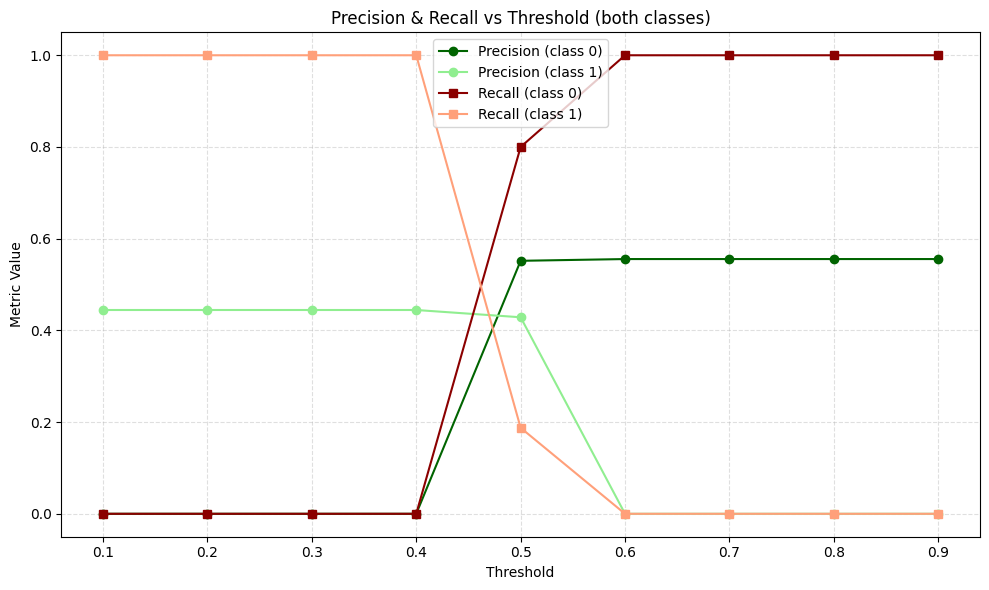

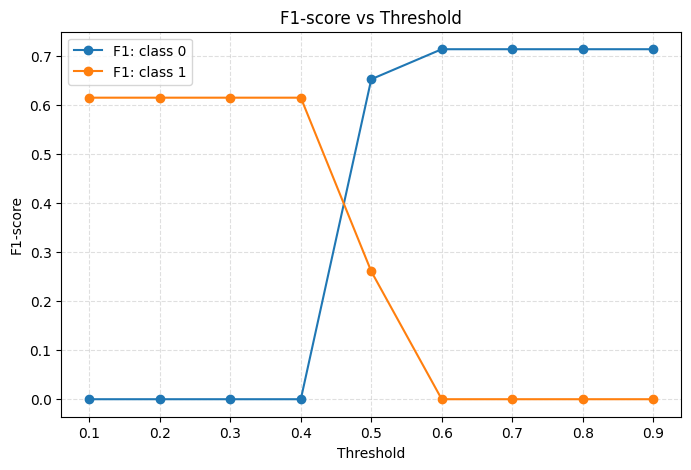

In [12]:
plot_precision_recall_both_classes(metrics)
plot_f1(metrics)